In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
import librosa
from transformers import ASTForAudioClassification, ASTFeatureExtractor

class MusicGenreDataset(Dataset):
    def __init__(self, root_dir, feature_extractor, max_duration=35):  # max_duration in seconds
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.max_duration = max_duration
        self.genres = os.listdir(root_dir)
        self.file_paths = []
        self.labels = []

        for genre in self.genres:
            genre_dir = os.path.join(root_dir, genre)
            for file_name in os.listdir(genre_dir):
                if file_name.endswith('.mp3'):
                    self.file_paths.append(os.path.join(genre_dir, file_name))
                    self.labels.append(self.genres.index(genre))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        waveform, sample_rate = torchaudio.load(file_path)

        # Convert stereo to mono if necessary
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        waveform = waveform.squeeze().numpy()
        waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)

        # Calculate the start and end indices for the middle 30 seconds
        total_samples = len(waveform)
        start_sample = max(0, (total_samples - self.max_duration * 16000) // 2)
        end_sample = min(total_samples, start_sample + self.max_duration * 16000)
        waveform = waveform[start_sample:end_sample]

        # Calculate max_length based on max_duration
        max_length = self.max_duration * 16000
        inputs = self.feature_extractor(waveform, sampling_rate=16000, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
        inputs["labels"] = torch.tensor(label)
        return inputs

# Initialize the feature extractor
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Create the dataset
dataset = MusicGenreDataset(root_dir="/kaggle/input/fourdifferentmusicclassifications", feature_extractor=feature_extractor, max_duration=35)

# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(train_size) 
print(test_size)

# Create dataloaders for training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

153
39


In [3]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import get_scheduler
from tqdm import tqdm

# Initialize the model with ignore_mismatched_sizes=True
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", num_labels=len(dataset.genres), ignore_mismatched_sizes=True)

# Reinitialize the classifier layer to match the number of genres
in_features = model.classifier.dense.in_features
model.classifier.dense = torch.nn.Linear(in_features, len(dataset.genres))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Calculate the number of training steps
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)

# Initialize the learning rate scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)



Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: 100%|██████████| 10/10 [03:40<00:00, 22.07s/it, loss=0.0484]


Epoch 0 - Average Training Loss: 0.47721666693687437
Epoch 0 - Average Test Loss: 0.21369499961535135, Test Accuracy: 0.9487179487179487


Epoch 1: 100%|██████████| 10/10 [03:21<00:00, 20.20s/it, loss=0.00403]


Epoch 1 - Average Training Loss: 0.03265473060309887
Epoch 1 - Average Test Loss: 0.2534839529544115, Test Accuracy: 0.9487179487179487


Epoch 2: 100%|██████████| 10/10 [03:18<00:00, 19.83s/it, loss=0.00121]


Epoch 2 - Average Training Loss: 0.013978215656243265
Epoch 2 - Average Test Loss: 0.1919473713884751, Test Accuracy: 0.9743589743589743


Epoch 3: 100%|██████████| 10/10 [03:18<00:00, 19.89s/it, loss=0.0157]


Epoch 3 - Average Training Loss: 0.005530238139908761
Epoch 3 - Average Test Loss: 0.16897445203115544, Test Accuracy: 0.9743589743589743


Epoch 4: 100%|██████████| 10/10 [03:17<00:00, 19.77s/it, loss=0.00125]


Epoch 4 - Average Training Loss: 0.0029683742090128363
Epoch 4 - Average Test Loss: 0.17232619412243366, Test Accuracy: 0.9743589743589743
Training time: 1225.39 seconds


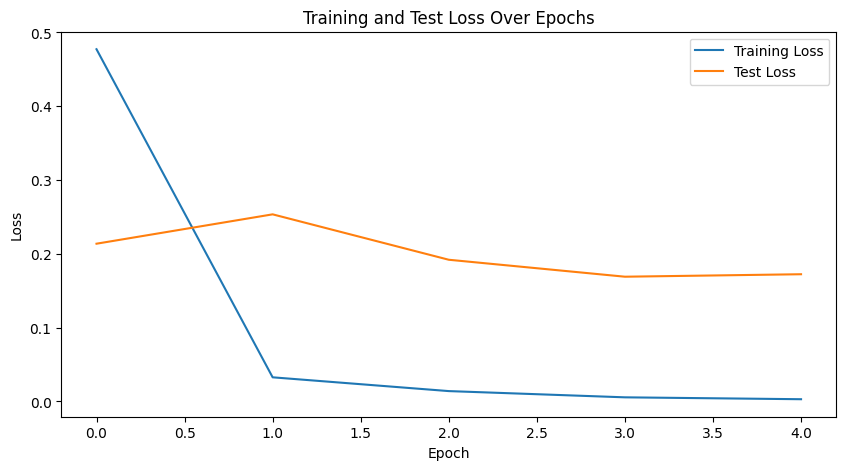

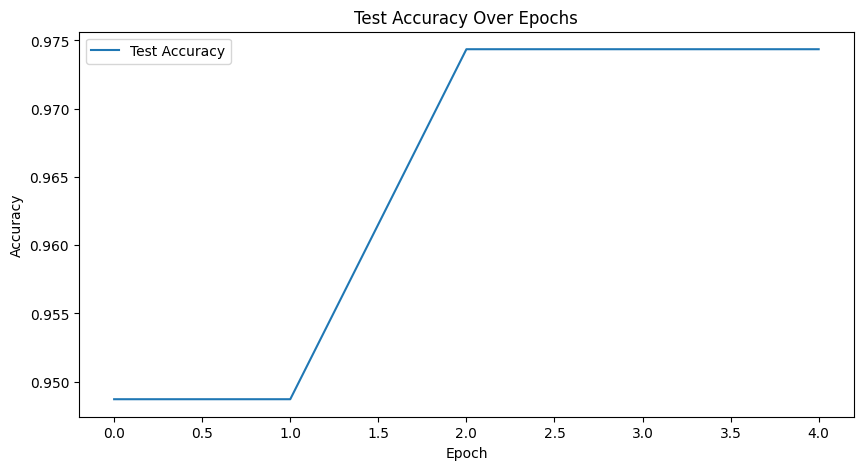

In [4]:
from tqdm import tqdm
import time

def train_model(model, train_dataloader, test_dataloader, optimizer, lr_scheduler, num_epochs, device):
    train_losses = []
    test_losses = []
    test_accuracies = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        loop = tqdm(train_dataloader, leave=True)
        for batch in loop:
            inputs = batch['input_values'].squeeze(1).to(device)  # Extract and squeeze the spectrogram
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_values=inputs, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Update the progress bar
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch} - Average Training Loss: {avg_train_loss}")

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch in test_dataloader:
                inputs = batch['input_values'].squeeze(1).to(device)  # Extract and squeeze the spectrogram
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(input_values=inputs, labels=labels)
                loss = outputs.loss
                test_loss += loss.item()

                # Get predictions
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)
                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.size(0)

        avg_test_loss = test_loss / len(test_dataloader)
        test_accuracy = correct_predictions / total_predictions
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch} - Average Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")

    end_time = time.time()
    training_time = end_time - start_time

    return train_losses, test_losses, test_accuracies, training_time

# Train the model
train_losses, test_losses, test_accuracies, training_time = train_model(
    model, train_dataloader, test_dataloader, optimizer, lr_scheduler, num_epochs, device
)



# Print training time
print(f"Training time: {training_time:.2f} seconds")

import matplotlib.pyplot as plt

# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Plot test accuracies
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.show()

# Save the fine-tuned model
model.save_pretrained("fine-tuned-ast-model")

In [10]:
import torch
from transformers import ASTForAudioClassification

def load_fine_tuned_model(model_path, num_labels, device):
    """
    Load a fine-tuned ASTForAudioClassification model from the specified path.

    Args:
        model_path (str): The path to the directory where the fine-tuned model is saved.
        num_labels (int): The number of labels (genres) the model was fine-tuned on.
        device (torch.device): The device to load the model onto (e.g., 'cuda' or 'cpu').

    Returns:
        model (ASTForAudioClassification): The loaded fine-tuned model.
    """
    # Load the model architecture
    model = ASTForAudioClassification.from_pretrained(model_path, num_labels=num_labels)

    # Move the model to the specified device
    model.to(device)

    return model


# # Define the path to the saved model
# model_path = "/kaggle/input/modelast/tensorflow2/default/1"

# # Define the number of labels (genres) the model was fine-tuned on
# num_labels = len(dataset.genres)

# # Define the device to load the model onto
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the fine-tuned model
# model2 = load_fine_tuned_model(model_path, num_labels, device)

# print(model2)

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       